In [1]:
from helpers import backends, detector, models, df_metrics, delete_representations, get_id, live_capture, visulaize_frame
import cv2
from cv2 import VideoCapture
from deepface import DeepFace
import os

In [2]:
def register_face(id, image_path=None, live = False):
    result = {"success": False, "message": "", "id": id, "image_path": ""}

    # check for duplicate id
    if id + '.jpg' in os.listdir(os.getcwd() + '/img_db/'):
        print("id already exists")
        result["message"] = "id already exists"
        check = input("Enter new id or enter 'x' to quit: ").lower()
        if check == 'x':
            print("exiting command...")
            result["message"] = "exiting command..."
            return result
        else:
            id = check
            
    if live:
        # take in image from cam
        cap = VideoCapture(0)
        
        while True:
            ret, frame = cap.read()
            face = detector(frame)
            if face:
                # crop and save image
                x, y , w, h = face[0]['facial_area'].values()
                cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 3)
                crop_img = frame[y:y+h, x:x+w]

                # Display the image with the detected face
                cv2.imshow('detect face', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    result["message"] = "quit detected. No face detected in the provided image"
                    break
                    
                if cv2.waitKey(1) & 0xFF == ord('c'):
                    # Save face
                    face_path = os.path.join(os.getcwd() + '/img_db/', id + '.jpg')
                    # face_path = "/img_db/"+id+".jpg"
                    cv2.imwrite(face_path, crop_img)
                    print(f" id {id} registered successfully")
                    print(f"image stored in {face_path}")

                    delete_representations()
                    result["success"] = True
                    result["message"] = f"id {id} registered successfully"
                    result["image_path"] = face_path
                    break
            
            else:
                # if no face detected
                h,w = frame.shape[:2]
                text = 'Adjust face and brightness'
                font = cv2.FONT_HERSHEY_SIMPLEX
                fontsize = 1  
                color = (0,255,0)
                thickness = 2
                text_size, _ = cv2.getTextSize(text, font, fontsize, thickness)

                x = (w - text_size[0]) // 2  
                y = (h + text_size[1]) // 2
                cv2.putText(frame, text, (x, y), font, fontsize, color, thickness)
                # cv2.putText(frame, text, (10, h - 20), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0,), 1)
                # cv2.putText(crop_img, 'Align face', (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                cv2.imshow('detect face', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    result["message"] = "quit detected. No face detected in the provided image"
                    break
                
        cv2.destroyAllWindows()
        cap.release()
        return result
                    

    # Load the image
    else:
        # check image_path is not None
        if image_path is None:
            result["message"] = "image_path is None"
            print(result["message"])
            return result
        
        frame = cv2.imread(image_path)

        # perform face detection
        face = detector(frame)
        if face:
            # crop and save image
            x, y , w, h = face[0]['facial_area'].values()
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 3)
            crop_img = frame[y:y+h, x:x+w]

            # Display the image with the detected face
            # cv2.imshow('detect face', frame)
            # cv2.waitKey(0)

            # Save face
            face_path = os.path.join(os.getcwd() + '/img_db/', id + '.jpg')
            # face_path = "/img_db/"+id+".jpg"
            cv2.imwrite(face_path, crop_img)
            print(f" id {id} registered successfully")
            print(f"image stored in {face_path}")

            delete_representations()
            result["success"] = True
            result["message"] = f"id {id} registered successfully"
            result["image_path"] = face_path
            return result
        
        else:
            result["message"] = "No face detected in the provided image"
            print(result["message"])
            cv2.destroyAllWindows()
            return result

In [2]:
# detect face using static image
# take in the path to the image database
# image_path comes from live_capture function or
# local path to image
def face_detect(image_path, db_path):
    dfs = []
    try:
        df = DeepFace.find(img_path=image_path, db_path=db_path, model_name=models[2], 
                            distance_metric=df_metrics[2], enforce_detection=False)
                        #    detector_backend=backends[0])
        dfs.append(df)
    except Exception as e:
        print(f"Error in reading image: {e}")
    


    if dfs:
        try:
            user_id = get_id(dfs)
        except Exception as e:
            print(f"Error in get_id: {e}")
    else:
        user_id = None

    return user_id    

In [6]:
my_id = face_detect(image_path = live_capture(), db_path="./img_db/")

24-01-26 23:57:19 - ⚠️ Representations for images in ./img_db/ folder were previously stored in representations_facenet512.pkl. If you added new instances after the creation, then please delete this file and call find function again. It will create it again.
24-01-26 23:57:19 - There are 16 representations found in representations_facenet512.pkl
24-01-26 23:57:20 - find function lasts 0.9071674346923828 seconds


In [5]:
my_id

'mme173412.jpg'

In [19]:
image_path = "./feed_img/grace.jpg"
id = input("Enter id: ")
# img_path = "./feed_img/IMG_20180924_131019.jpg"
# id = "mcs172757"
# img_path = "./feed_img/IMG_20180924_131019.jpg"
register_face(id, image_path = image_path)
# register_face(id, live=True)

 id urp174028 registered successfully
image stored in c:\Users\biodu\Desktop\me\anew_work\deploy-face-model\facemodel\ImageProcessor/img_db/urp174028.jpg
previous representations deleted


{'success': True,
 'message': 'id urp174028 registered successfully',
 'id': 'urp174028',
 'image_path': 'c:\\Users\\biodu\\Desktop\\me\\anew_work\\deploy-face-model\\facemodel\\ImageProcessor/img_db/urp174028.jpg'}

In [31]:
db_path = "./img_db/"
id = face_detect(db_path)
print(id)

There are  13  representations found in  representations_facenet512.pkl
find function lasts  0.8511660099029541  seconds
age191234.jpg


In [ ]:
def live(**kwargs):
    # take in image from cam
    cap = VideoCapture(0)
    
    while True:
        ret, frame = cap.read()
        face = detector(frame)
        if face:
            # crop and save image
            x, y , w, h = face[0]['facial_area'].values()
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 3)
            crop_img = frame[y:y+h, x:x+w]

            # Display the image with the detected face
            cv2.imshow('detect face', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                result["message"] = "quit detected. No face detected in the provided image"
                break
                
            if cv2.waitKey(1) & 0xFF == ord('c'):
                # Save face
                face_path = os.path.join(os.getcwd() + '/img_db/', id + '.jpg')
                # face_path = "/img_db/"+id+".jpg"
                cv2.imwrite(face_path, crop_img)
                print(f" id {id} registered successfully")
                print(f"image stored in {face_path}")

                delete_representations()
                result["success"] = True
                result["message"] = f"id {id} registered successfully"
                result["image_path"] = face_path
                break
        
        else:
            # if no face detected
            h,w = frame.shape[:2]
            text = 'Adjust face and brightness'
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontsize = 1  
            color = (0,255,0)
            thickness = 2
            text_size, _ = cv2.getTextSize(text, font, fontsize, thickness)

            x = (w - text_size[0]) // 2  
            y = (h + text_size[1]) // 2
            cv2.putText(frame, text, (x, y), font, fontsize, color, thickness)
            # cv2.putText(frame, text, (10, h - 20), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0,), 1)
            # cv2.putText(crop_img, 'Align face', (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            cv2.imshow('detect face', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                result["message"] = "quit detected. No face detected in the provided image"
                break
            
    cv2.destroyAllWindows()
    cap.release()
    return result

In [192]:
def register_face(id):
    # check for duplicate id
    if id + '.jpg' in os.listdir(os.getcwd() + '/img_db/'):
        print("id already exists")
        check = input("Enter new id or enter 'x' to quit: ").lower()
        if check == 'x':
            print("exiting command...")
            return
        else:
            id = check
            
    cap = VideoCapture(0)

    while True:
        ret, frame = cap.read()
        face = detector(frame)
        if face:
            # crop and save image
            x,y,w,h = face[0]['facial_area'].values()
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 3)
            crop_img = frame[y:y+h, x:x+w]
            cv2.imshow('detect face', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            elif cv2.waitKey(1) & 0xFF == ord('c'):
                # save face
                face_path = "/img_db/"+id+".jpg"
                cv2.imwrite(face_path, crop_img)
                print(f" id {id} registered successfully")
                print(f"image stored in {face_path}")
                delete_representations()
                
                break
        else:
            # if no face detected
            h,w = frame.shape[:2]
            text = 'Adjust face and brightness'
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontsize = 1  
            color = (0,255,0)
            thickness = 2
            text_size, _ = cv2.getTextSize(text, font, fontsize, thickness)

            x = (w - text_size[0]) // 2  
            y = (h + text_size[1]) // 2
            cv2.putText(frame, text, (x, y), font, fontsize, color, thickness)
            # cv2.putText(frame, text, (10, h - 20), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0,), 1)
            # cv2.putText(crop_img, 'Align face', (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            cv2.imshow('detect face', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows() 

In [172]:
id = input("Enter id: ")
register_face(id)

id already exists
 id mme173416 registered successfully
image stored in /img_db/mme173416.jpg
previous representations deleted


In [173]:
def face_detect():
    cap = cv2.VideoCapture(0)
    dfs = []
    
    while True:
        ret, frame = cap.read()

        if ret == False:
            break
        
        face = detector(frame)
        if face is not None:
            # face detection and recognition logic
            x,y,w,h = face[0]['facial_area'].values()  
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255, 0), 3)
            # cv2.imshow('detect face', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('c'):
                df = DeepFace.find(img_path=frame, db_path="./img_db/", model_name=models[2], 
                                   distance_metric=df_metrics[2], enforce_detection=False)
                                #    detector_backend=backends[0])
                dfs.append(df)
                break

        cv2.imshow('display', frame)
                
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

    user_id = get_id(dfs)
    
    return user_id

In [174]:
face_result = face_detect()

Finding representations: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


24-01-15 09:52:53 - Representations stored in ./img_db//representations_facenet512.pkl file.Please delete this file when you add new identities in your database.
24-01-15 09:52:54 - find function lasts 3.8008406162261963 seconds


In [191]:
face_result

'mee173322.jpg'

In [159]:
def check_duplicate_registration(id):
    if id in os.listdir(os.getcwd() + '/img_db/'):
        return True
    else:
        return False

In [ ]:
def face_detect():
    cap = cv2.VideoCapture(0)
    dfs = []
    
    while True:
        ret, frame = cap.read()

        if ret == False:
            break
        
        face = detector(frame)
        if face is not None:
            # face detection and recognition logic
            x,y,w,h = face[0]['facial_area'].values()  
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255, 0), 3)
            # cv2.imshow('detect face', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('c'):
                df = DeepFace.find(img_path=frame, db_path="./img_db/", model_name=models[2], 
                                   distance_metric=df_metrics[2], enforce_detection=False)
                                #    detector_backend=backends[0])
                dfs.append(df)
                break

        cv2.imshow('display', frame)
                
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

    user_id = get_id(dfs)
    
    return user_id

In [2]:
# a function that takes an images and performs 
dfs = DeepFace.find(img_path="./feed_img/input_image.jpg", db_path="./img_db/", enforce_detection=False)

Finding representations: 100%|██████████| 2/2 [00:09<00:00,  4.92s/it]


24-01-16 08:07:50 - Representations stored in ./img_db//representations_vgg_face.pkl file.Please delete this file when you add new identities in your database.
24-01-16 08:07:52 - find function lasts 10.952213048934937 seconds


In [3]:
dfs

[                  identity  target_x  target_y  target_w  target_h  source_x  \
 0  ./img_db//mme172415.jpg         0         0       197       197         0   
 1  ./img_db//mee173322.jpg        10        11       132       132         0   
 
    source_y  source_w  source_h  VGG-Face_cosine  
 0         0       250       250         0.296485  
 1         0       250       250         0.334520  ]

In [8]:
def get_id(list_list_df):
    df = list_list_df[0]
    df['identity'] = df['identity'].apply(lambda x: x.split("/")[-1])
    name = df.iloc[0][0]
    return name

In [9]:
get_id(dfs)

'mme172415.jpg'

In [33]:
def face_detect(image_path, db_path):
    img_arr = cv2.imread(image_path)
    face_objs = DeepFace.extract_faces(img_path = img_arr, 
        target_size = (224, 224), 
        detector_backend = backends[4])

    face = face_objs[0]['face']
    
    try:
        dfs = DeepFace.find(img_path=face, db_path=db_path,
                            model_name="Facenet512", distance_metric="euclidean_l2",
                            detector_backend = backends[0],
                            enforce_detection=False)
        
    except Exception as e:
        print(f"Error in DeepFace.find: {e}")


    def get_id(list_list_df):
        df = list_list_df[0]
        df['identity'] = df['identity'].apply(lambda x: x.split("/")[-1])
        name = df.iloc[0][0]
        return name
    
    user_id = get_id(dfs)
    
    return user_id

    # return dfs


In [ ]:
face_detect(image_path=, db_path=)

In [74]:
img_arr = cv2.imread("./feed_img/jkjjksgkgk.jpg")
face_objs = DeepFace.extract_faces(img_path = img_arr, 
    target_size = (224, 224), 
    detector_backend = backends[4])

face = face_objs[0]['face']
dfs = DeepFace.find(img_path=face, db_path="./img_db/",
                            model_name="Facenet512", distance_metric="euclidean_l2",
                            detector_backend = backends[0],
                            enforce_detection=False)

Finding representations: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


24-01-16 09:19:01 - Representations stored in ./img_db//representations_facenet512.pkl file.Please delete this file when you add new identities in your database.
24-01-16 09:19:02 - find function lasts 1.9341373443603516 seconds


Series([], Name: identity, dtype: object)

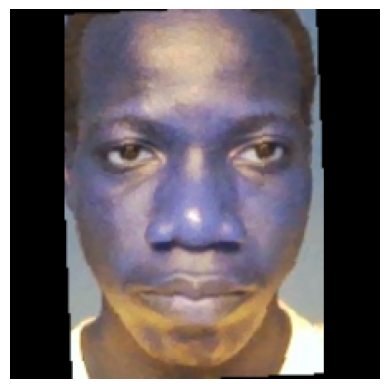

In [76]:
visulaize_frame(face_objs[0]['face'])